# K-means Clustering
https://spark.apache.org/docs/3.3.0/ml-clustering.html#k-means

In [1]:
from sklearn.datasets import load_iris
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import PCA as PCAml
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.clustering import KMeans
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# アヤメの品種データ（Iris plants dataset）の読み込み
df_iris = load_iris(as_frame=True)

In [3]:
# 説明変数を取得
#pd_df_iris = pd.DataFrame(df_iris.data, columns=df_iris.feature_names)
X = pd.DataFrame(df_iris.data, columns=df_iris.feature_names)
# 目的変数を取得
#pd_df_iris['target'] = pd.Series(df_iris.target)
y = pd.Series(df_iris.target, name='target')

# 説明変数と目的変数を結合して、1つのDataFrameにする
pd_df_iris = pd.merge(X, y, how="left", left_index=True, right_index=True)

In [4]:
spark = SparkSession.builder \
    .appName("kmeans-spark") \
    .getOrCreate()

In [5]:
# pysparkDataFrameに変換
spark_df_iris = spark.createDataFrame(pd_df_iris)

/usr/local/spark/python/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/usr/local/spark/python/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


In [6]:
spark_df_iris.count()

150

In [7]:
spark_df_iris.show()

+-----------------+----------------+-----------------+----------------+------+
|sepal length (cm)|sepal width (cm)|petal length (cm)|petal width (cm)|target|
+-----------------+----------------+-----------------+----------------+------+
|              5.1|             3.5|              1.4|             0.2|     0|
|              4.9|             3.0|              1.4|             0.2|     0|
|              4.7|             3.2|              1.3|             0.2|     0|
|              4.6|             3.1|              1.5|             0.2|     0|
|              5.0|             3.6|              1.4|             0.2|     0|
|              5.4|             3.9|              1.7|             0.4|     0|
|              4.6|             3.4|              1.4|             0.3|     0|
|              5.0|             3.4|              1.5|             0.2|     0|
|              4.4|             2.9|              1.4|             0.2|     0|
|              4.9|             3.1|              1.

In [8]:
# 各品種のサンプル数
spark_df_iris.groupBy("target").count().show()

+------+-----+
|target|count|
+------+-----+
|     0|   50|
|     1|   50|
|     2|   50|
+------+-----+



In [9]:
spark_df_iris = spark_df_iris.drop("target")

In [10]:
spark_df_iris.count()

150

In [11]:
spark_df_iris.show()

+-----------------+----------------+-----------------+----------------+
|sepal length (cm)|sepal width (cm)|petal length (cm)|petal width (cm)|
+-----------------+----------------+-----------------+----------------+
|              5.1|             3.5|              1.4|             0.2|
|              4.9|             3.0|              1.4|             0.2|
|              4.7|             3.2|              1.3|             0.2|
|              4.6|             3.1|              1.5|             0.2|
|              5.0|             3.6|              1.4|             0.2|
|              5.4|             3.9|              1.7|             0.4|
|              4.6|             3.4|              1.4|             0.3|
|              5.0|             3.4|              1.5|             0.2|
|              4.4|             2.9|              1.4|             0.2|
|              4.9|             3.1|              1.5|             0.1|
|              5.4|             3.7|              1.5|          

In [12]:
assemble = VectorAssembler(inputCols=['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)'], outputCol='iris_features')
assembled_data = assemble.transform(spark_df_iris)

In [13]:
assembled_data.show()

+-----------------+----------------+-----------------+----------------+-----------------+
|sepal length (cm)|sepal width (cm)|petal length (cm)|petal width (cm)|    iris_features|
+-----------------+----------------+-----------------+----------------+-----------------+
|              5.1|             3.5|              1.4|             0.2|[5.1,3.5,1.4,0.2]|
|              4.9|             3.0|              1.4|             0.2|[4.9,3.0,1.4,0.2]|
|              4.7|             3.2|              1.3|             0.2|[4.7,3.2,1.3,0.2]|
|              4.6|             3.1|              1.5|             0.2|[4.6,3.1,1.5,0.2]|
|              5.0|             3.6|              1.4|             0.2|[5.0,3.6,1.4,0.2]|
|              5.4|             3.9|              1.7|             0.4|[5.4,3.9,1.7,0.4]|
|              4.6|             3.4|              1.4|             0.3|[4.6,3.4,1.4,0.3]|
|              5.0|             3.4|              1.5|             0.2|[5.0,3.4,1.5,0.2]|
|         

In [14]:
silhouette_scores = []
evaluator = ClusteringEvaluator(featuresCol='iris_features', metricName='silhouette', distanceMeasure='squaredEuclidean')

In [15]:
for K in range(2, 11):
    # Trains a k-means model.
    kmeans = KMeans(featuresCol='iris_features', k=K, seed=1)
    model = kmeans.fit(assembled_data)
    # Make predictions
    predictions = model.transform(assembled_data)
    # Evaluate clustering by computing Silhouette score
    evaluation_score = evaluator.evaluate(predictions)
    silhouette_scores.append(evaluation_score)

Text(0, 0.5, 'Silhouette Score')

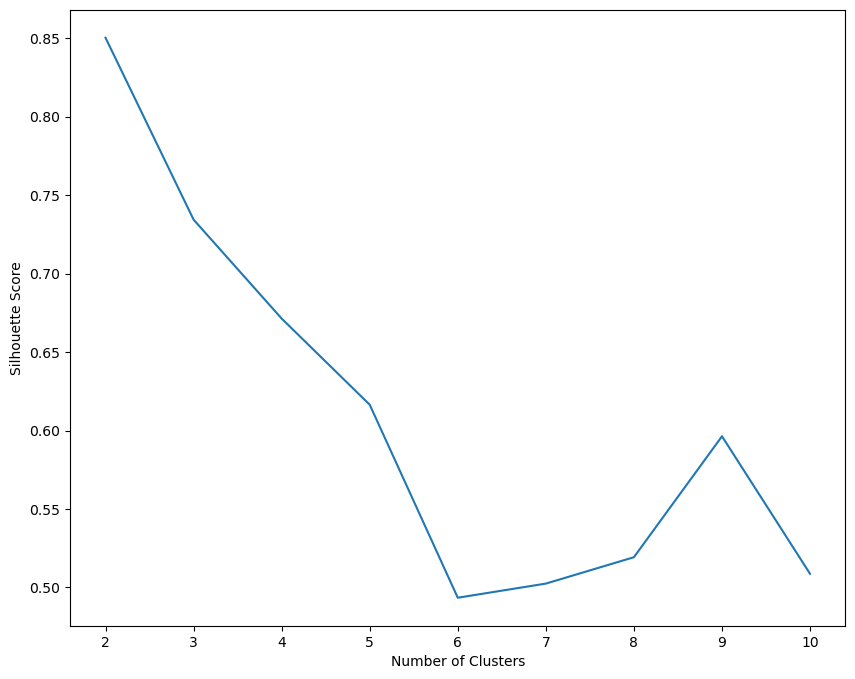

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(10,8))
ax.plot(range(2,11), silhouette_scores)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Silhouette Score')

In [17]:
# Trains a k-means model.
kmeans = KMeans(featuresCol='iris_features', k=3, seed=1)
model = kmeans.fit(assembled_data)
# Make predictions
predictions = model.transform(assembled_data)

In [18]:
predictions.show()

+-----------------+----------------+-----------------+----------------+-----------------+----------+
|sepal length (cm)|sepal width (cm)|petal length (cm)|petal width (cm)|    iris_features|prediction|
+-----------------+----------------+-----------------+----------------+-----------------+----------+
|              5.1|             3.5|              1.4|             0.2|[5.1,3.5,1.4,0.2]|         1|
|              4.9|             3.0|              1.4|             0.2|[4.9,3.0,1.4,0.2]|         1|
|              4.7|             3.2|              1.3|             0.2|[4.7,3.2,1.3,0.2]|         1|
|              4.6|             3.1|              1.5|             0.2|[4.6,3.1,1.5,0.2]|         1|
|              5.0|             3.6|              1.4|             0.2|[5.0,3.6,1.4,0.2]|         1|
|              5.4|             3.9|              1.7|             0.4|[5.4,3.9,1.7,0.4]|         1|
|              4.6|             3.4|              1.4|             0.3|[4.6,3.4,1.4,0.3]|  

In [19]:
# 各クラスタのサンプル数
predictions.groupBy("prediction").count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   50|
|         2|   61|
|         0|   39|
+----------+-----+



In [20]:
# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator(featuresCol='iris_features', metricName='silhouette', distanceMeasure='squaredEuclidean')
silhouette = evaluator.evaluate(predictions)
print("K={}".format(3))
print("シルエット係数：{}" .format(str(silhouette)))

K=3
シルエット係数：0.7344130579787828


In [21]:
# Shows the result.
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[6.85384615 3.07692308 5.71538462 2.05384615]
[5.006 3.428 1.462 0.246]
[5.88360656 2.74098361 4.38852459 1.43442623]


In [22]:
pca = PCAml(k=2, inputCol="iris_features", outputCol="pca")
pca_model = pca.fit(assembled_data)
pca_transformed = pca_model.transform(assembled_data)

In [23]:
pca_transformed.show()

+-----------------+----------------+-----------------+----------------+-----------------+--------------------+
|sepal length (cm)|sepal width (cm)|petal length (cm)|petal width (cm)|    iris_features|                 pca|
+-----------------+----------------+-----------------+----------------+-----------------+--------------------+
|              5.1|             3.5|              1.4|             0.2|[5.1,3.5,1.4,0.2]|[-2.8182395066394...|
|              4.9|             3.0|              1.4|             0.2|[4.9,3.0,1.4,0.2]|[-2.7882234453146...|
|              4.7|             3.2|              1.3|             0.2|[4.7,3.2,1.3,0.2]|[-2.6133745635497...|
|              4.6|             3.1|              1.5|             0.2|[4.6,3.1,1.5,0.2]|[-2.7570222769675...|
|              5.0|             3.6|              1.4|             0.2|[5.0,3.6,1.4,0.2]|[-2.7736485960544...|
|              5.4|             3.9|              1.7|             0.4|[5.4,3.9,1.7,0.4]|[-3.2215054997645...|
|

In [24]:
x_pca = np.array(pca_transformed.rdd.map(lambda row: row.pca).collect())

In [25]:
cluster_assignment = np.array(predictions.rdd.map(lambda row: row.prediction).collect()).reshape(-1, 1)

In [26]:
pca_data = np.hstack((x_pca, cluster_assignment))

In [27]:
pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal", "cluster_assignment"))

In [28]:
pca_df

,1st_principal,2nd_principal,cluster_assignment
0,-2.818240,-5.646350,1.0
1,-2.788223,-5.149951,1.0
2,-2.613375,-5.182003,1.0
3,-2.757022,-5.008654,1.0
4,-2.773649,-5.653707,1.0
...,...,...,...
145,-7.446475,-5.514485,0.0
146,-7.029532,-4.951636,2.0
147,-7.266711,-5.405811,0.0
148,-7.403307,-5.443581,0.0


In [29]:
#custom_palette = ["red", "green", "orange", "blue", "yellow", "purple"]
custom_palette = ['#FBB4AE', '#B3CDE3', '#CCEBC5',  '#DECBE4', '#FED9A6', '#FFFFCC',  '#E5D8BD', '#FDDAEC', '#F2F2F2']
sns.set_palette(custom_palette) 

/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]


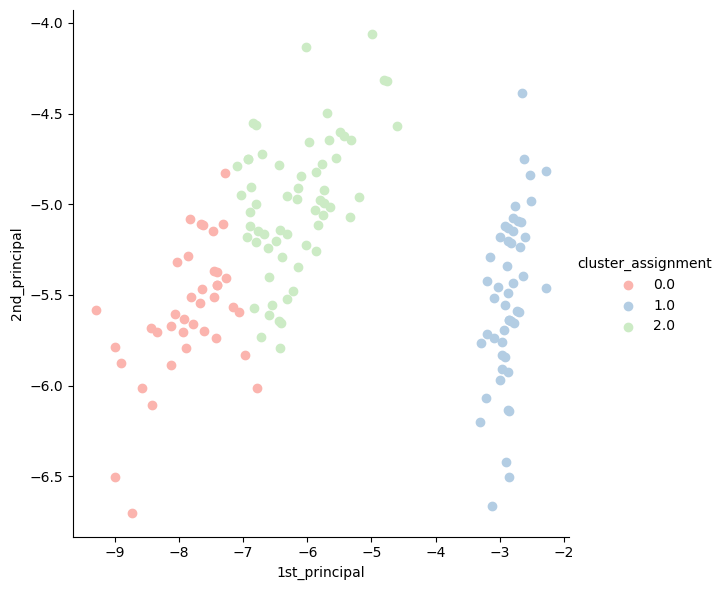

In [30]:
sns.FacetGrid(pca_df, hue="cluster_assignment", height=6).map(plt.scatter, '1st_principal', '2nd_principal').add_legend()
plt.savefig("predictions_scatter.png", format="png", dpi=300)
plt.show()

In [31]:
pca_df['target'] = pd.Series(df_iris.target)

In [32]:
pca_df

,1st_principal,2nd_principal,cluster_assignment,target
0,-2.818240,-5.646350,1.0,0
1,-2.788223,-5.149951,1.0,0
2,-2.613375,-5.182003,1.0,0
3,-2.757022,-5.008654,1.0,0
4,-2.773649,-5.653707,1.0,0
...,...,...,...,...
145,-7.446475,-5.514485,0.0,2
146,-7.029532,-4.951636,2.0,2
147,-7.266711,-5.405811,0.0,2
148,-7.403307,-5.443581,0.0,2


In [33]:
#custom_palette = ["red", "green", "orange", "blue", "yellow", "purple"]
custom_palette = ['#B3CDE3', '#CCEBC5', '#FBB4AE',  '#DECBE4', '#FED9A6', '#FFFFCC',  '#E5D8BD', '#FDDAEC', '#F2F2F2']
sns.set_palette(custom_palette) 

/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]


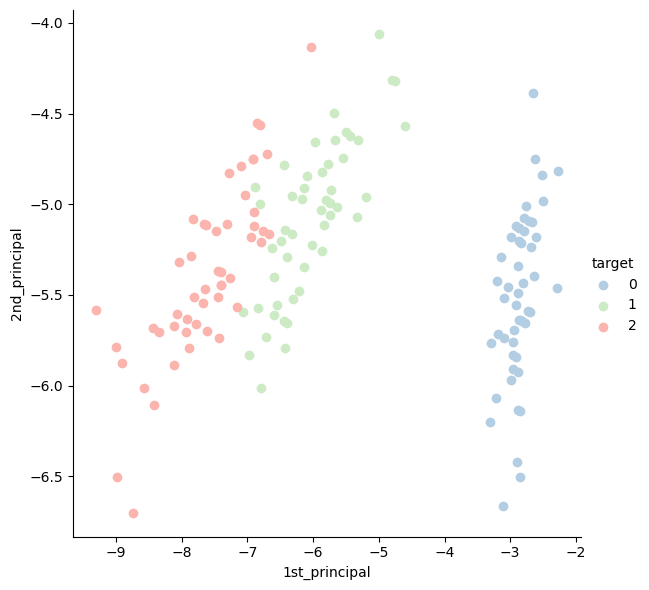

In [34]:
sns.FacetGrid(pca_df, hue="target", height=6).map(plt.scatter, '1st_principal', '2nd_principal').add_legend()
plt.savefig("target_scatter.png", format="png", dpi=300)
plt.show()

In [35]:
spark.stop()